In [ ]:
# Define input and output file paths
input_path = "/content/drive/MyDrive/Videos/Test1"  # Adjust path as needed
output_path = "/content/drive/MyDrive/Videos/Test1.mp4"
cropped_output_path = "/content/drive/MyDrive/Videos/Test1_cropped.mp4"
xlsx_path = "/content/drive/MyDrive/collected_data/Test1_data.xlsx"


In [ ]:
# run if video in in .mov
!apt-get install -y ffmpeg

# Convert MOV to MP4
!ffmpeg -i "{input_path}" -vcodec libx264 -preset ultrafast -crf 23 "{output_path}"



^C
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --e

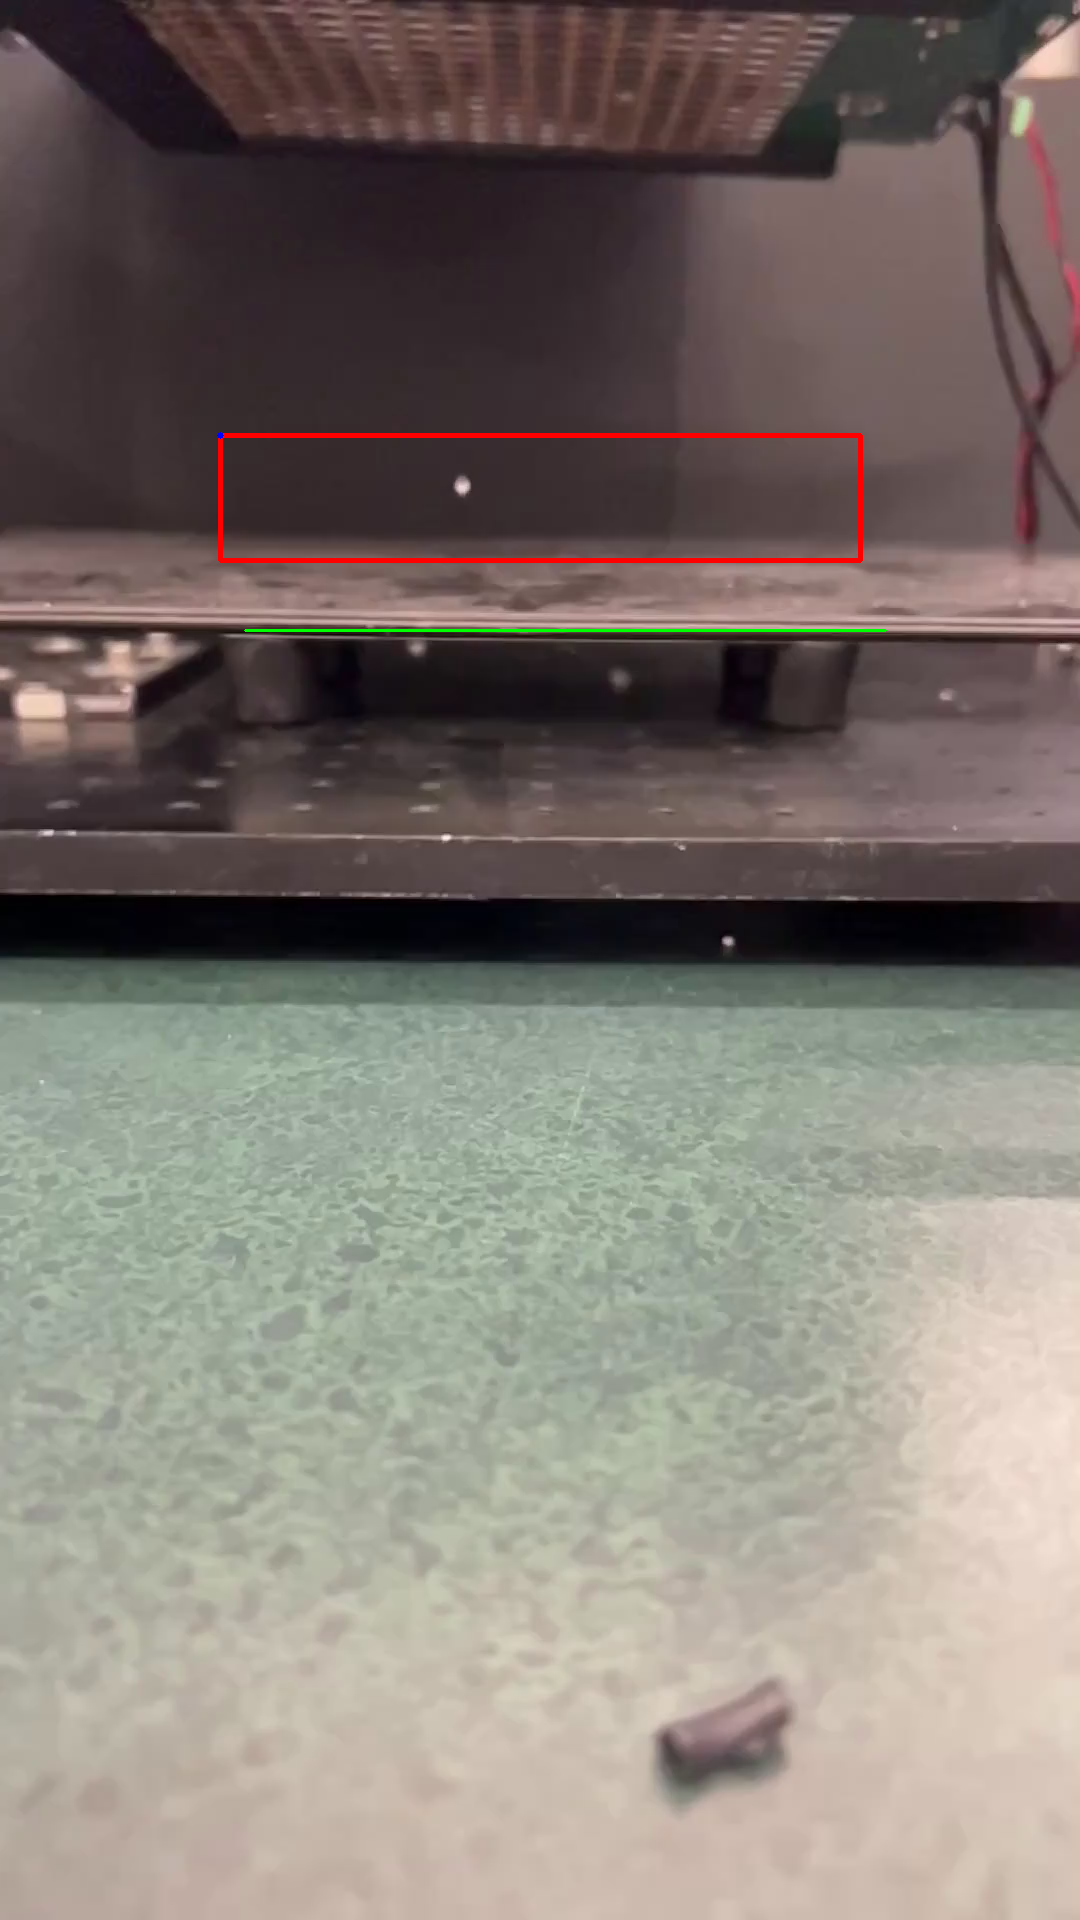

In [ ]:
# for tuning conversion ration from pixels to cm and cropping

import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import csv

MAX_FRAME = 2
i = 0
reference_object_length = 19
# Load video
cap = cv2.VideoCapture(output_path)
x_start = 245
x_end = 885
y_start = 630
y_end = 630

x1, y1, x2, y2 = 220, 560, 860, 435

while True:
    ret, frame = cap.read()
    i = i + 1
    if i >= MAX_FRAME:
        break

    start_point = (x_start, y_start)   # (x, y) coordinates
    end_point = (x_end, y_end)

    # Define color (BGR format) and thickness
    color = (0, 255, 0)  # Green
    thickness = 2        # Line thickness

    # Draw the line
    cv2.line(frame, start_point, end_point, color, thickness)

    #Draw Rectangle for Cropping
    cv2.rectangle(frame,(x1, y1), (x2, y2), (0, 0, 255), 3)
    cv2.circle(frame, (x1, y2), radius=3, color=(255, 0, 0), thickness=-1)

    # Show frame
    cv2_imshow(frame)

cap.release()

PIXELS_PER_CM = (x_end - x_start)/reference_object_length


In [ ]:
#crop video based on red box
import os
length = x2-x1
height = y1-y2
#!ffmpeg -i "{output_path}"  -filter:v "crop={len}:{height}:{x1}:{y2}" -c:a copy cropped_output_path
os.system(f'ffmpeg -i "{output_path}" -filter:v "crop={length}:{height}:{x1}:{y2}" -c:a copy "{cropped_output_path}"')

256

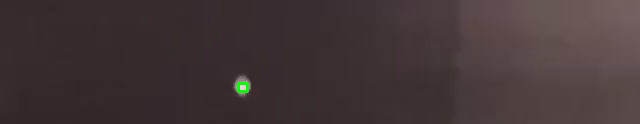

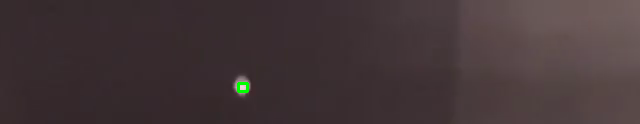

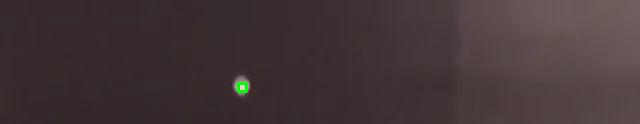

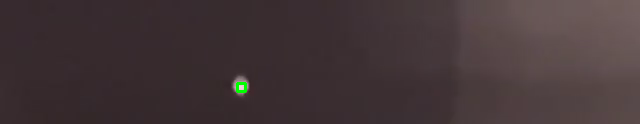

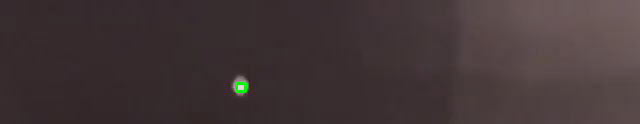

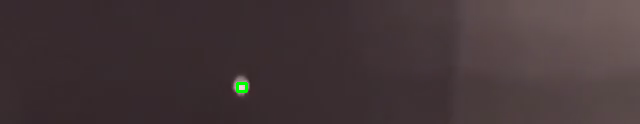

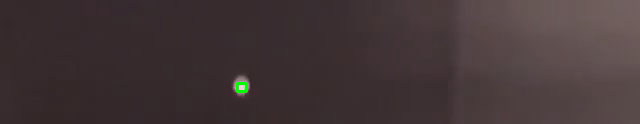

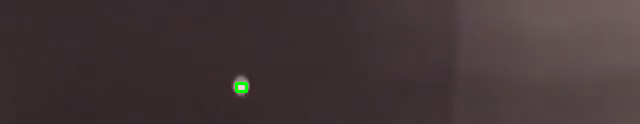

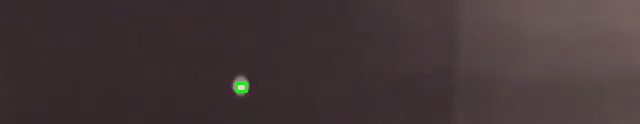

In [ ]:
#Run this first to be sure that the filters are propoerly tracking the bead
import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import csv


# Constants (adjust these based on calibration)
FPS = 240  # Frames per second of the video
MAX_DISPLACEMENT = 1000  # Maximum pixel distance to associate objects across frames
i = 0
MAX_FRAME = 10

# Load video
cap = cv2.VideoCapture(cropped_output_path)

# Initialize background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Dictionary to store object tracking data
object_data = {}  # Format: {object_id: {'position': (x, y), 'time': timestamp}}
object_id_counter = 0  # Unique ID for tracking objects

while True:
    ret, frame = cap.read()
    i = i + 1
    if i >= MAX_FRAME:
        break

    # Preprocessing for white object detection
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    #cv2_imshow(hsv)
    lower_white = np.array([0, 0, 160])  # Lower boundary for white color in HSV
    upper_white = np.array([180, 100, 255])  # Upper boundary for white color in HSV
    mask = cv2.inRange(hsv, lower_white, upper_white)
    #cv2_imshow(mask)
    mask = cv2.GaussianBlur(mask, (11, 11), 0)
    _, thresh = cv2.threshold(mask, 220, 255, cv2.THRESH_BINARY)

    # Find contours of white, round objects
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    current_objects = {}  # Stores detected objects in the current frame
    for contour in contours:
        if cv2.contourArea(contour) > 1 and cv2.contourArea(contour) < 1000:  # Filter small objects
            x, y, w, h = cv2.boundingRect(contour)
            center = (int(x + w / 2), int(y + h / 2))

            # Match this object with an existing tracked object
            matched_id = None
            for obj_id, data in object_data.items():
                prev_center = data['position']
                if np.linalg.norm(np.array(center) - np.array(prev_center)) < MAX_DISPLACEMENT:
                    matched_id = obj_id
                    break

            # If no match found, assign a new ID
            if matched_id is None:
                matched_id = object_id_counter
                object_id_counter += 1

            current_time = time.time()
            if matched_id in object_data:
                prev_time = object_data[matched_id]['time']
                distance_pixels = np.linalg.norm(np.array(center) - np.array(object_data[matched_id]['position']))
                distance_meters = distance_pixels / PIXELS_PER_CM
                time_diff = current_time - prev_time
                speed = distance_meters / time_diff if time_diff > 0 else 0

                # Display speed
                #cv2.putText(frame, f"ID {matched_id}: {speed:.2f} m/s", (x, y - 10),
                            #cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

            # Update tracking data
            current_objects[matched_id] = {'position': center, 'time': current_time}

            # Draw bounding box
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Update stored object data
    object_data = current_objects

    # Show frame

    cv2_imshow(frame)

cap.release()



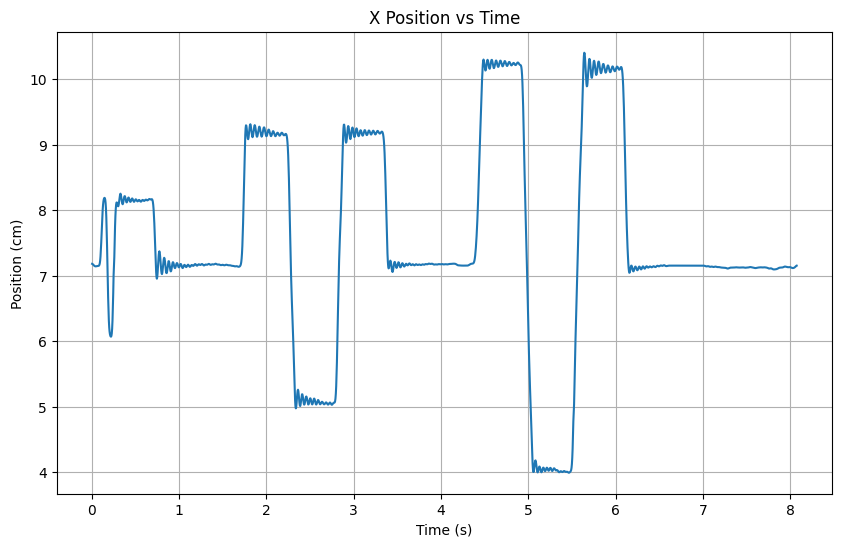

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import time
import matplotlib.pyplot as plt
import csv
import scipy.ndimage
from moviepy.video.io.VideoFileClip import VideoFileClip

# Constants (adjust these based on calibration)
FPS = 240  # Frames per second of the video
MAX_DISPLACEMENT = 10000  # Maximum pixel distance to associate objects across frames
i = 0
MAX_FRAME = 100000
SIGMA = 3


# Data storage for CSV export
tracked_data = []
x_pos = []
y_pos = []
time_track = []

# Load video
cap = cv2.VideoCapture(cropped_output_path)

# Initialize background subtractor
fgbg = cv2.createBackgroundSubtractorMOG2()

# Dictionary to store object tracking data
object_data = {}  # Format: {object_id: {'x': [], 'y': [], 'time': []}}
object_id_counter = 0  # Unique ID for tracking objects

while True:
    ret, frame = cap.read()
    i += 1
    if i >= MAX_FRAME or not ret:
        break

    # Preprocessing for white object detection
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    #cv2_imshow(hsv)
    lower_white = np.array([0, 0, 200])  # Lower boundary for white color in HSV
    upper_white = np.array([180, 50, 255])  # Upper boundary for white color in HSV
    mask = cv2.inRange(hsv, lower_white, upper_white)
    #cv2_imshow(mask)
    mask = cv2.GaussianBlur(mask, (11, 11), 0)
    _, thresh = cv2.threshold(mask, 220, 255, cv2.THRESH_BINARY)

    # Find contours of white, round objects
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    current_objects = {}  # Stores detected objects in the current frame
    for contour in contours:

      if 1 < cv2.contourArea(contour) < 1000:  # Filter small objects
            x, y, w, h = cv2.boundingRect(contour)
            center = (int(x + w / 2), int(y + h / 2))

            # Match this object with an existing tracked object
            matched_id = None
            for obj_id, data in object_data.items():
                prev_center = (data['x'][-1], data['y'][-1])
                if np.linalg.norm(np.array(center) - np.array(prev_center)) < MAX_DISPLACEMENT:
                    matched_id = obj_id
                    break

            # If no match found, assign a new ID
            if matched_id is None:
                matched_id = object_id_counter
                object_data[matched_id] = {'x': [], 'y': [], 'time': []}  # Initialize tracking data
                object_id_counter += 1

            # Update tracking data
            current_time = time.time()
            object_data[matched_id]['x'].append(center[0])
            object_data[matched_id]['y'].append(center[1])
            object_data[matched_id]['time'].append(i / FPS)

            # Append data in the format [object_id, time, x, y]
            tracked_data.append([i / FPS, center[0], center[1]])
            time_track.append(i/FPS)
            x_pos.append(center[0])
            y_pos.append(center[1])

# Plotting X and Y position over time
plt.figure(figsize=(10, 6))
x_scaled = []
y_scaled = []
time = data['time']

for x in x_pos:
  x_scaled.append(x/PIXELS_PER_CM)
for y in y_pos:
  y_scaled.append(y/PIXELS_PER_CM)

x_gaussian = scipy.ndimage.gaussian_filter1d(x_scaled, sigma=SIGMA)

for obj_id, data in object_data.items():
    plt.plot(data['time'], x_gaussian, label=f'Object {obj_id} - X position')
    #plt.plot(data['time'], data['y'], label=f'Object {obj_id} - Y position')

plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')
plt.title('X Position vs Time')
#plt.legend()
#plt.xlim(1, 45)
#plt.ylim(8,18)
plt.grid(True)
plt.show()



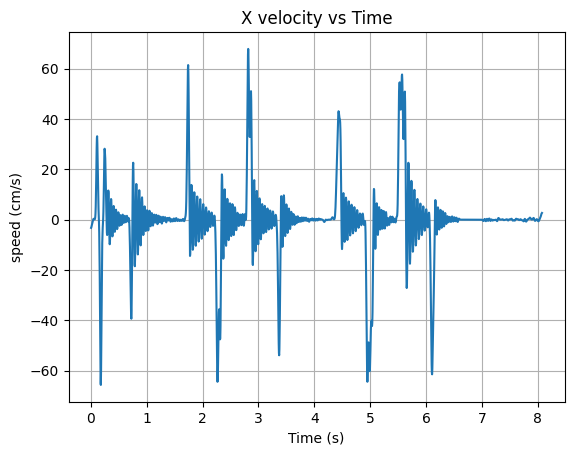

In [ ]:
#plots speec vs time,
k = 1


speed = []
for i in range(0, len(x_scaled)-k):
  speed.append((x_scaled[i+k]-x_scaled[i])/(time[i+k]-time[i]))

for j in range(0, k):
  speed.append(speed[len(speed) - 1])

speed_gaussian = scipy.ndimage.gaussian_filter1d(speed, sigma=SIGMA)

plt.plot(time, speed_gaussian)
plt.xlabel('Time (s)')
plt.ylabel('speed (cm/s)')
plt.title('X velocity vs Time')
#plt.legend()
#plt.xlim(1.5, 45)
#plt.ylim(-100, 100)
plt.grid(True)
plt.show()


  plt.legend()



1936


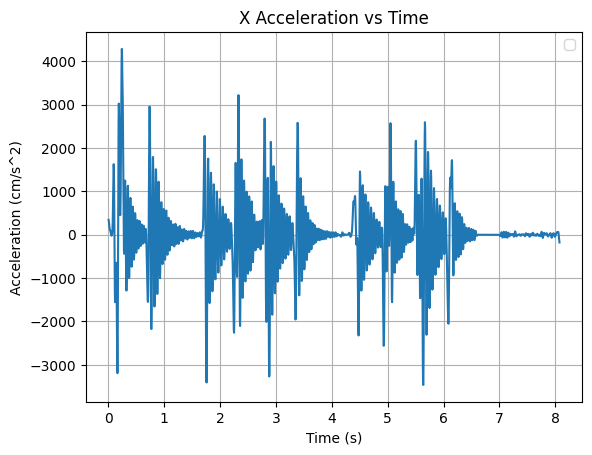

In [ ]:
#plots acceleration vs time

k = 1

accel = []
print(len(speed))
for i in range(0, len(speed)-k):
  accel.append((speed[i+k]-speed[i])/(time[i+k]-time[i]))

for j in range(0, k):
  accel.append(accel[len(accel) - 1])

accel_gaussian = scipy.ndimage.gaussian_filter1d(accel, sigma=SIGMA)

plt.plot(time, accel_gaussian)
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (cm/s^2)')
plt.title('X Acceleration vs Time')
plt.legend()
#plt.xlim(1.5, 45)
#plt.ylim(-2500, 2500)
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

title = xlsx_path #MODIFY THIS BASED ON WHAT UR VARYING!!!

# Convert to DataFrame
df = pd.DataFrame({
    'pixels per cm': PIXELS_PER_CM,
    'Frames per second' : FPS,
    'Time (s)': time,
    'sigma': SIGMA,
    'X_pos (pixels)': x_pos,
    'X Scaled (cm)': x_scaled,
    'X_gaussian (cm)': x_gaussian,
    'X_Velocity (cm/s)' : speed,
    'X_V_gaussian (cm/s)': speed_gaussian,
    'X_acceleration (cm/s^2)' : accel,
    'X_A_gaussian (cm/s^2)' : accel_gaussian
})

# Export to Excel
df.to_excel(title , index=False)  # Saves without an index

print("Data exported")

Data exported


52.46305418723723


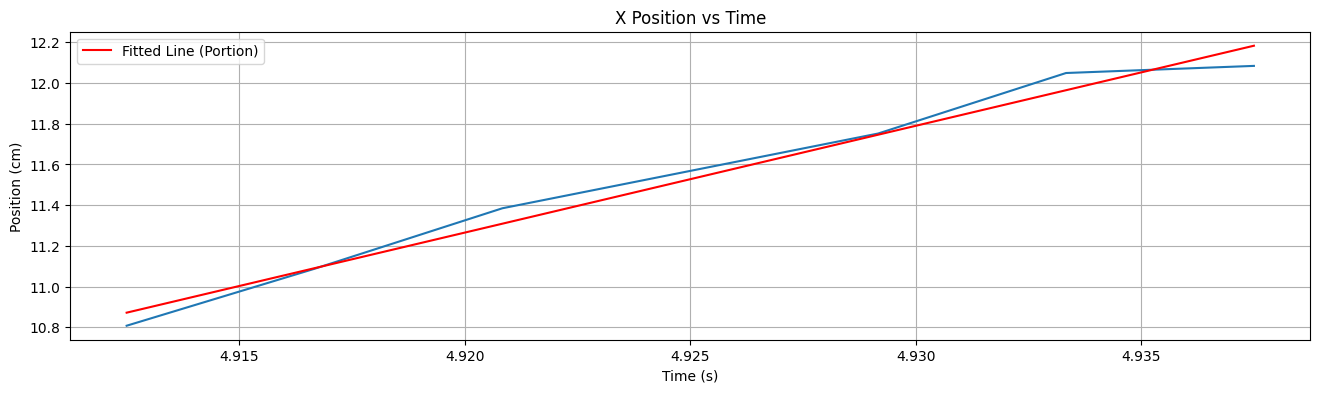

In [ ]:
#lin reg for speed measurements

from scipy.stats import linregress

masked_data = [(ti, xi) for ti, xi in zip(time_track, x_scaled) if 4.91 <= ti <= 4.94]
t_fit, x_fit = zip(*masked_data)

slope, intercept, r_value, p_value, std_err = linregress(t_fit, x_fit)
print(slope)

x_line = []
for t in t_fit:
  x_line.append(t*slope + intercept)

f = plt.figure()
f.set_figwidth(16)
f.set_figheight(4)

plt.plot(t_fit, x_fit)
plt.plot(t_fit, x_line, color='red', label='Fitted Line (Portion)')
plt.xlabel('Time (s)')
plt.ylabel('Position (cm)')
plt.title('X Position vs Time')
plt.legend()
plt.grid(True)
plt.show()
